# Steps

* Entender PSI E KS
* Calcular essas métricas com dados sintéticos.
* Pegar um notebook no Kaggle de credit score e aplicar os modelos Xgboost e LightGBM.
* Calcular PSI e KS pra esses dados.

## (PSI Population Stability Index)

Population Stability Index (PSI) compares the distribution of predicted probability in scoring data with predicted probability in training data.  
The idea is to check “How different the current scored data is, compared to the training data”.

$$
PSI = \sum_{i=1}^{k} \left( (O_i - E_i) \times \ln\left(\frac{O_i}{E_i}\right) \right)
$$

In [150]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [151]:
# Development dataset
dev_data = pd.DataFrame({'score': np.random.randint(150, 1000 ,1000)}).sort_values(by='score', ascending=True)
# Validation dataset
val_data = pd.DataFrame({'score': np.random.randint(150, 1000 ,1000)}).sort_values(by='score', ascending=True)
# Create ExcelWriter object
with pd.ExcelWriter("data.xlsx", engine='openpyxl', if_sheet_exists='replace', mode='a') as writer:
    # Save dev_data to "dev" sheet
    dev_data.to_excel(writer, sheet_name="dev", index=False)
    
    # Save val_data to "val" sheet
    val_data.to_excel(writer, sheet_name="val", index=False)

def population_stability_index(dev_data, val_data, col_name, num_bins = 10):
    # bins = np.linspace(dev_data[col_name].min(), dev_data[col_name].max(), num=num_bins+1)
    bins = np.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]) # For simplicity

    dev_data['bin'] = pd.cut(dev_data[col_name], bins=bins, include_lowest=True, ordered=True)
    val_data['bin'] = pd.cut(val_data[col_name], bins=bins, include_lowest=True, ordered=True)

    dev_group = dev_data.groupby('bin', observed=False)[col_name].count().reset_index(name='dev_count')
    val_group = val_data.groupby('bin', observed=False)[col_name].count().reset_index(name='val_count')

    merged_counts = dev_group.merge(val_group, on='bin', how='left')

    small_constant = 1e-10 # avoid division by zero
    merged_counts['dev_pct'] = (merged_counts['dev_count'] / len(dev_data) + small_constant)
    merged_counts['val_pct'] = (merged_counts['val_count'] / len(val_data) + small_constant)
    merged_counts['psi'] = (merged_counts['val_pct'] - merged_counts['dev_pct']) * np.log(merged_counts['val_pct'] / merged_counts['dev_pct'])

    return merged_counts['psi'].sum(), merged_counts

def plot_psi(plot_data, psi_value):    
    fig, ax = plt.subplots(figsize=(15, 8))  # Adjust the chart size here
    index = np.arange(len(plot_data))
    bar_width = 0.35
    dev_bars = ax.bar(index, plot_data['dev_pct'], bar_width, label='Development')
    val_bars = ax.bar(index + bar_width, plot_data['val_pct'], bar_width, label='Validation')
    
    # Annotating each bar with its count
    for bar, dev_count, val_count in zip(index, plot_data['dev_count'], plot_data['val_count']):
        ax.text(bar, plot_data['dev_pct'][bar] + 0.01, str(dev_count), ha='center', va='bottom')
        ax.text(bar + bar_width, plot_data['val_pct'][bar] + 0.01, str(val_count), ha='center', va='bottom')

    ax.set_xlabel('Bins')
    ax.set_ylabel('Percentage')
    ax.set_title(f'Population Stability Index (PSI): {psi_value:.4f}')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(plot_data['bin'].apply(lambda x: f"{x.left:.2f}-{x.right:.2f}"))
    ax.legend()
    fig.tight_layout()
    plt.show()

In [152]:
psi_value, merged_counts = population_stability_index(dev_data, val_data, 'score', 10)
print(f'PSI value: {psi_value}')

PSI value: 0.023253508313900027


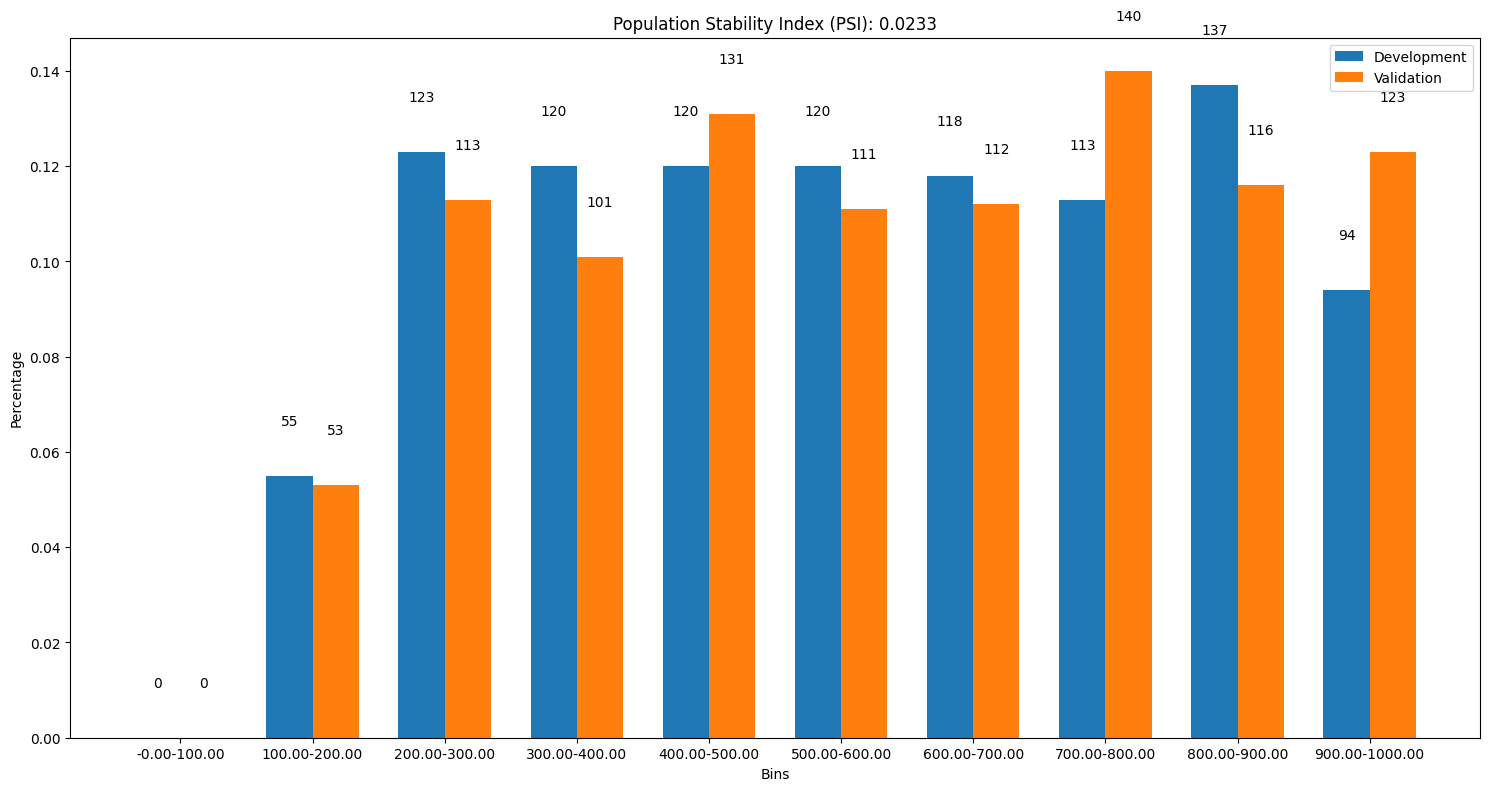

In [153]:
plot_psi(merged_counts, psi_value)

# KS